# <span style="color:#3363ae">**WebScraping Comisión para el Mercado Financiero**</span>.
Este Proyecto es un *WebScraping* de la CMF en donde se extraen todos los estados financieros de una empresa y luego se crea un excel con su balance en una hoja y sus EERR en la otra. Posteriormente este código se mejorará y se podrán extraer datos históricos de esa empresa con el fin de hacer un modelo que valorize la empresa. En este caso vamos a partir con <span style="color:#3363ae">**CMPC**</span>.

In [2]:
#Como siempre importamos las librerias necesarias para ejecutar nuestro codigo.
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC





Para poder ejecutar este código, es necesario obtener manualmente dos valores específicos relacionados con la empresa a analizar. Estos valores se detallan a continuación:

Obtener el enlace de la empresa:
1. Primero, identifique la empresa en el sitio web de la Comisión para el <span style="color:#3363ae">__Mercado Financiero de Chile (CMF)__</span>. dentro del portal de entidades fiscalizadas. Para este ejemplo, seleccionaremos la empresa CMPC. Acceda al sitio web de la CMF y realice una búsqueda en el apartado de entidades fiscalizadas, siguiendo el enlace de la empresa de interés. Una vez encontrado, copie el enlace completo de la página fiscalizada de la empresa y almacénelo como una cadena de texto en la primera posición ([0]) de la lista __Empresa__. El enlace debería tener una estructura similar al siguiente: https://www.cmfchile.cl/portal/principal/613/w3-search.php?keywords=cmpc#fiscalizados.

2. <span style="color:#3363ae">__Especificar el RUT__</span> de la empresa: El segundo valor requerido es el __RUT__ (Rol Único Tributario) de la empresa seleccionada. En este caso, se utilizará el RUT de CMPC, que es <span style="color:#3363ae">__90222000__</span>. Almacene este número en formato de cadena de texto en la segunda posición ([1]) de la lista __Empresa__.

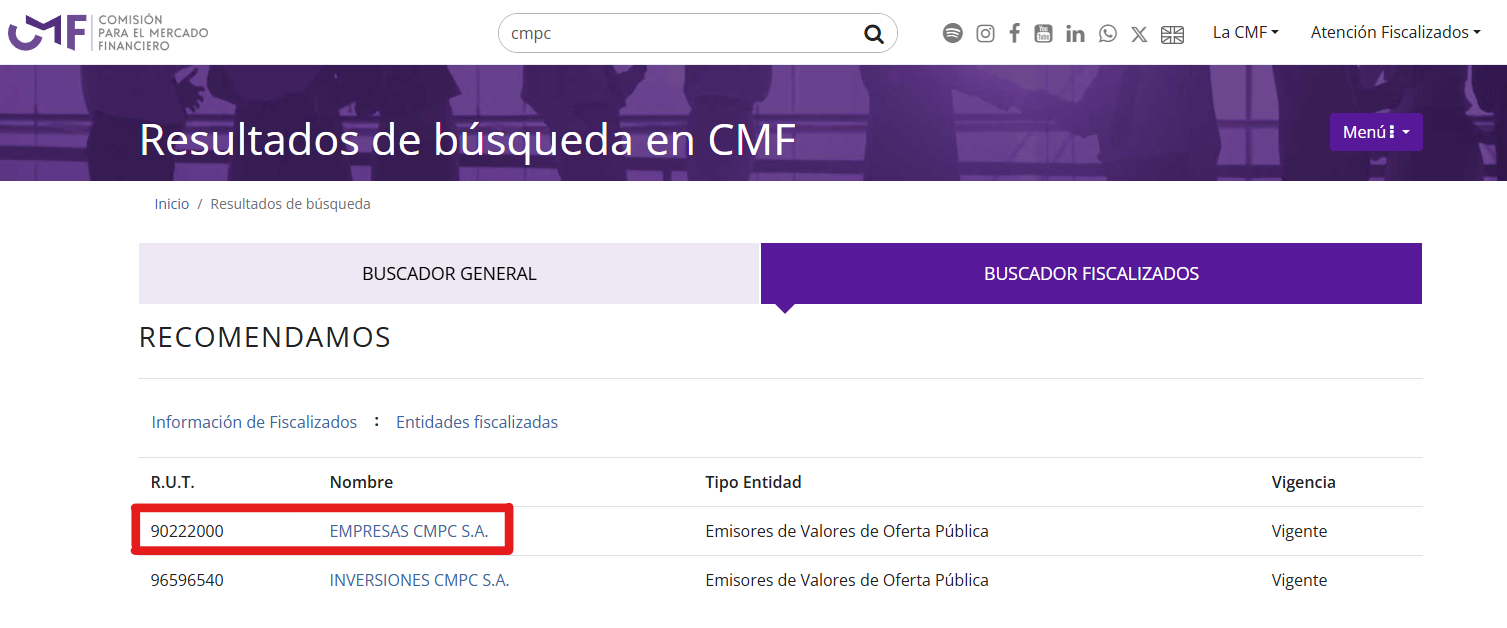

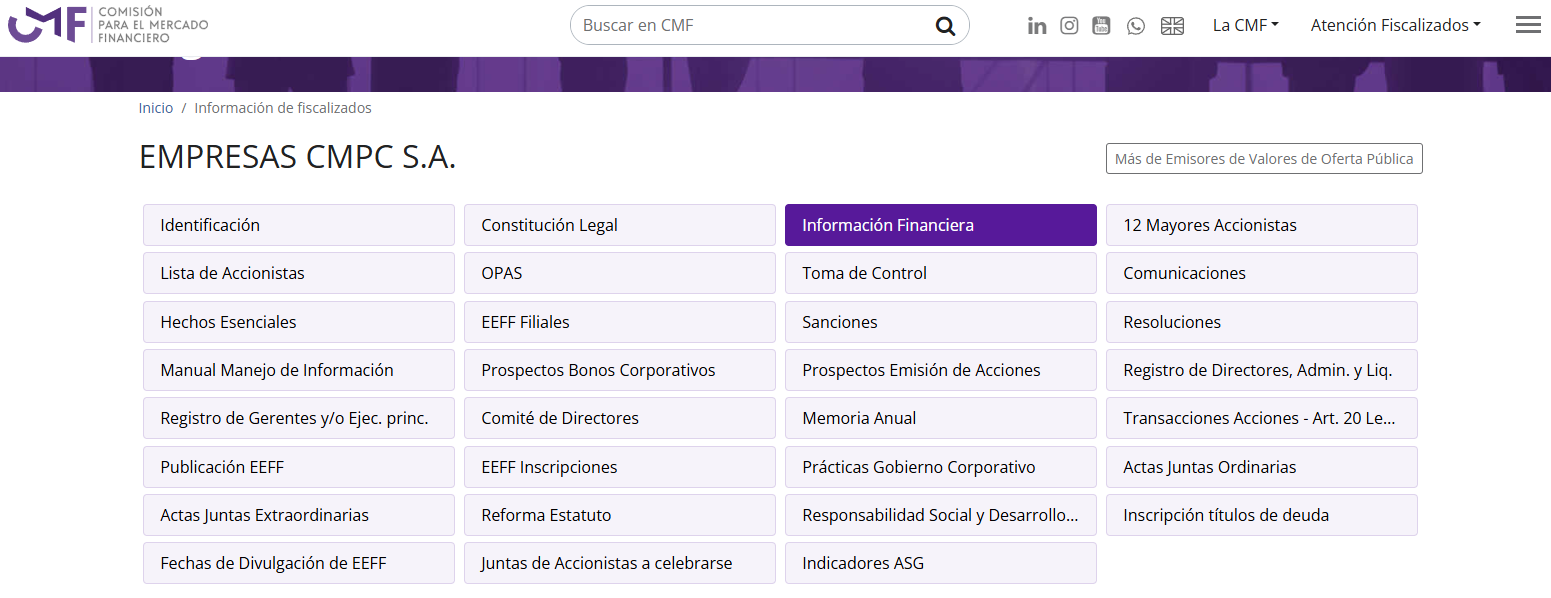

In [3]:
Empresa = ['https://www.cmfchile.cl/portal/principal/613/w3-search.php?keywords=cmpc#fiscalizados',"//td[text()='90222000']","./following-sibling::td/a"]
keys = ["Url", "selector1", "Selector2"]

Respecto al periodo que queremos extraer necesitaremos manipularlo en la lista __configurador__, para ello, debemos seleccionar 3 variables:
1. Año del cual extraeremos la información.
2. Quarter que queremos extraer.
3. Tipo de Norma, si es Estandar IFRS o Norma Chilena, en mi experiencia o al menos en las empresas que yo he mirado, generalemnte se utiliza el Estandar IFRS, ahí deben ir probando.

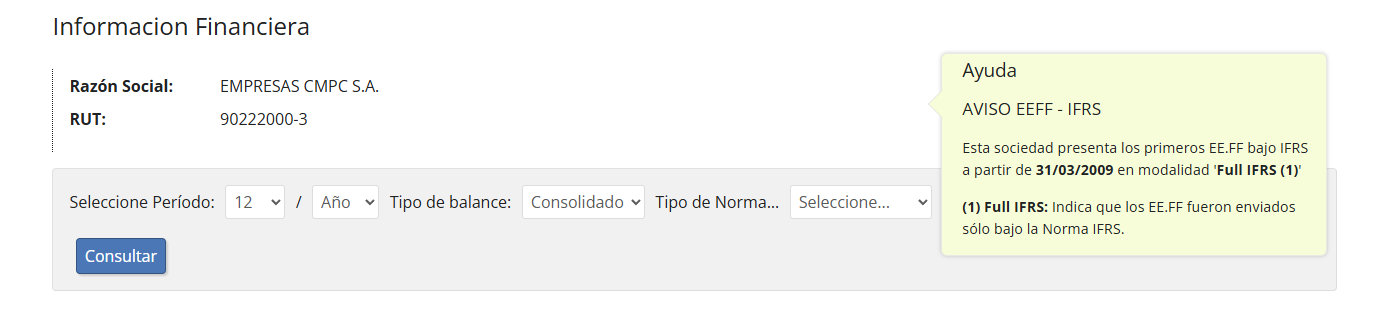

Solo como orientación dejo el orden de los periodos:
- año ["Año" ,2023, 2022, 2021, 2020, 2019, 2018...etc]
- Quarter [Q4, Q3, Q2, Q1]
- Tipo Norma ["Seleccione", "Estandar IFRS", "Norma Chilena"]

En el caso que queramos extraer el Q3 del 2021, tipo norma IFRS deberiamos usar la siguiente configuración:
- configurador [4,1,1]

In [4]:
año = ["Año" ,2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 20211, 2010, 2009, 2008, 2007, 2006, 2005]
quarter = ["Q4", "Q3", "Q2", "Q1"]
Tipo_Norma = ["Seleccione", "Estandar IFRS", "Norma Chilena"]


#----------Reemplazar valores en la siguiente lista ----------------------------
configurador = [3,1,1]

Ya nos vamos manos a la obra y empezar a manipular con Selenium

In [5]:
# Inicializar el navegador web
driver = webdriver.Chrome()

# Cargar la página de inicio de la empresa en este ejemplo, 
driver.get(Empresa[0])
time.sleep(2)
td_element = driver.find_element(By.XPATH,Empresa[1])
a_element = td_element.find_element(By.XPATH,Empresa[2])
a_element.click()
time.sleep(2)


estados_financieros = driver.find_element(By.XPATH, "//*[@id='listado_reportes']/li[3]/a")
estados_financieros.click()
time.sleep(2)

from selenium.webdriver.support.ui import Select

periodo = driver.find_element(By.ID,'mm')
# Crear un objeto Select a partir del elemento <select>
select_periodo = Select(periodo)
# Obtener todas las opciones del <select> en una lista
base_periodo = select_periodo.options
#--------------------------------------------------------
año = driver.find_element(By.ID,'aa')
# Crear un objeto Select a partir del elemento <select>
select_año = Select(año)
# Obtener todas las opciones del <select> en una lista
base_año = select_año.options
#--------------------------------------------------------
tipo_norma = driver.find_element(By.NAME,'tipo_norma')
# Crear un objeto Select a partir del elemento <select>
select_tipo_norma = Select(tipo_norma)
# Obtener todas las opciones del <select> en una lista
base_tipo_norma = select_tipo_norma.options

base_año[configurador[0]].click()
base_periodo[configurador[1]].click()
base_tipo_norma[configurador[2]].click()

time.sleep(2)
consulta = driver.find_element(By.XPATH, '//input[@alt="Consultar"]')
consulta.click()

Bien, ya accedimos a la información, puedes ver en la pestaña emergente que se abrió con Selenium la información del Balance y Estados de resultados de CMPC para el periodo seleccionado.\
Ahora la parte practica es que queremos pasar la información a una tabla Excel para poder manipular la información en esa herramienta.

# <span style="color:#3363ae">**Primero realizamos la tabla del Balance**</span>

In [6]:

# Esperar hasta que el elemento de la tabla esté presente
tabla_elemento = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, '//*[@id="listado_reportes"]/li[3]/a'))
)

# Una vez que la tabla esté cargada, obtén el HTML de la página
tabla_html = driver.page_source
soup = BeautifulSoup(tabla_html, 'html.parser')

# Obtener todas las tablas y seleccionar la segunda
tablas = soup.find_all('table')
tabla = tablas[1]  # Index 1 selecciona la segunda tabla
filas = tabla.find_all('tr')

# Buscar todas las tablas usando Selenium
tablas = driver.find_elements(By.TAG_NAME, 'table')

# Seleccionar la segunda tabla (índice 1)
tabla = tablas[1]

# Obtener encabezados
encabezados = []
for encabezado in tabla.find_elements(By.TAG_NAME,'th'):
    encabezados.append(encabezado.text)

# Verificar si los encabezados están vacíos
if not encabezados:
    print("No se encontraron encabezados")

# Obtener los datos de las filas
datos = []
for fila in tabla.find_elements(By.TAG_NAME,'tr'):
    fila_datos = []
    for celda in fila.find_elements(By.TAG_NAME,'td'):
        fila_datos.append(celda.text)
    
    # Asegurarse de que la fila tenga datos antes de agregarla
    if fila_datos:
        datos.append(fila_datos)

# Verificar si la cantidad de filas de datos coincide con los encabezados
if datos and len(encabezados) != len(datos[0]):
    print(f"El número de columnas no coincide. Encabezados: {len(encabezados)}, Datos: {len(datos[0])}")

# Crear el DataFrame si los encabezados y los datos son válidos
if encabezados and datos:
    df = pd.DataFrame(datos, columns=encabezados)
    print(df)
else:
    print("No se pudo crear el DataFrame. Verifica los datos.")

El número de columnas no coincide. Encabezados: 3, Datos: 1
   [210000] Estado de situación financiera, corriente/no corriente - Estados financieros consolidados\nMoneda: USD - Dólar estadounidense (Miles)  \
0                                  Activos [sinopsis]                                                                                               
1                       Activos corrientes [sinopsis]                                                                                               
2                 Efectivo y equivalentes al efectivo                                                                                               
3                Otros activos financieros corrientes                                                                                               
4             Otros activos no financieros corrientes                                                                                               
..                                            

In [7]:
df

,"[210000] Estado de situación financiera, corriente/no corriente - Estados financieros consolidados\nMoneda: USD - Dólar estadounidense (Miles)",2022-06-30,2021-12-31
0,Activos [sinopsis],None,None
1,Activos corrientes [sinopsis],None,None
2,Efectivo y equivalentes al efectivo,776.929,1.155.065
3,Otros activos financieros corrientes,85.729,24.959
4,Otros activos no financieros corrientes,170.331,155.611
...,...,...,...
62,Otras reservas,-957.171,-966.547
63,Patrimonio atribuible a los propietarios de la...,8.030.676,7.546.078
64,Participaciones no controladoras,2.829,2.872
65,Patrimonio total,8.033.505,7.548.950


# <span style="color:#3363ae">**Tabla del Estado de Resultados**</span>

In [8]:
# Esperar hasta que el elemento de la tabla esté presente
tabla_elemento = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, '//*[@id="listado_reportes"]/li[3]/a'))
)

# Una vez que la tabla esté cargada, obtén el HTML de la página
tabla_html = driver.page_source
soup = BeautifulSoup(tabla_html, 'html.parser')

# Obtener todas las tablas y seleccionar la segunda
tablas = soup.find_all('table')
tabla = tablas[1]  # Index 1 selecciona la segunda tabla
filas = tabla.find_all('tr')

# Buscar todas las tablas usando Selenium
tablas = driver.find_elements(By.TAG_NAME, 'table')

# Seleccionar la segunda tabla (índice 1)
tabla = tablas[2]

# Obtener encabezados
encabezados = []
for encabezado in tabla.find_elements(By.TAG_NAME,'th'):
    encabezados.append(encabezado.text)

# Verificar si los encabezados están vacíos
if not encabezados:
    print("No se encontraron encabezados")

# Obtener los datos de las filas
datos = []
for fila in tabla.find_elements(By.TAG_NAME,'tr'):
    fila_datos = []
    for celda in fila.find_elements(By.TAG_NAME,'td'):
        fila_datos.append(celda.text)
    
    # Asegurarse de que la fila tenga datos antes de agregarla
    if fila_datos:
        datos.append(fila_datos)

# Verificar si la cantidad de filas de datos coincide con los encabezados
if datos and len(encabezados) != len(datos[0]):
    print(f"El número de columnas no coincide. Encabezados: {len(encabezados)}, Datos: {len(datos[0])}")

# Crear el DataFrame si los encabezados y los datos son válidos
if encabezados and datos:
    df_eerr = pd.DataFrame(datos, columns=encabezados)
    print(df_eerr)
else:
    print("No se pudo crear el DataFrame. Verifica los datos.")

El número de columnas no coincide. Encabezados: 5, Datos: 1
   [310000] Estado del resultado, por función de gasto – Estados financieros consolidados\nMoneda: USD - Dólar estadounidense (Miles)  \
0                       Ganancia (pérdida) [sinopsis]                                                                                   
1                  Ingresos de actividades ordinarias                                                                                   
2                                     Costo de ventas                                                                                   
3                                      Ganancia bruta                                                                                   
4                                      Otros ingresos                                                                                   
5                              Costos de distribución                                                                 

In [9]:
df_eerr

,"[310000] Estado del resultado, por función de gasto – Estados financieros consolidados\nMoneda: USD - Dólar estadounidense (Miles)",Desde 2022-01-01\nHasta 2022-06-30,Desde 2022-04-01\nHasta 2022-06-30,Desde 2021-01-01\nHasta 2021-06-30,Desde 2021-04-01\nHasta 2021-06-30
0,Ganancia (pérdida) [sinopsis],None,None,None,None
1,Ingresos de actividades ordinarias,3.713.174,1.983.130,3.001.153,1.572.057
2,Costo de ventas,2.623.577,1.364.876,2.187.111,1.101.690
3,Ganancia bruta,1.089.597,618.254,814.042,470.367
4,Otros ingresos,74.486,42.364,69.000,34.379
5,Costos de distribución,156.161,83.104,129.586,65.563
6,Gastos de administración,184.056,102.920,157.413,78.348
7,"Otros gastos, por función",107.882,55.986,99.290,50.751
8,Otras ganancias (pérdidas),-59.430,-14.692,-21.405,-8.867
9,Ganancias (pérdidas) de actividades operacionales,656.554,403.916,475.348,301.217


# <span style="color:#3363ae">**Toda la info se almacena en un Excel**</span>

In [62]:
# Definir la ruta y el nombre del archivo Excel
ruta_archivo = 'C:/Users/josei/OneDrive/Escritorio/VARIOS/Web Scraping/estados_financieros.xlsx'

# Usar ExcelWriter para crear un archivo con varias hojas
with pd.ExcelWriter(ruta_archivo) as writer:
    df.to_excel(writer, sheet_name='Datos DF', index=False)      # Escribir el DataFrame `df` en la primera hoja
    df_eerr.to_excel(writer, sheet_name='Datos DF_EERR', index=False)  # Escribir el DataFrame `df_eerr` en la segunda hoja
